# CNN

In [73]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np 
import pandas as pd
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt 
%matplotlib inline

In [74]:
# Convert mnist image files into tensor of 4 Dimentions ( No. of images, height, width, color channel )
transform = transforms.ToTensor()

### Training Set
* Purpose: Used to train the model (adjust weights & biases via backpropagation).
    * Size: Usually larger (e.g., 70-80% of total data).
    * In MNIST: 60,000 handwritten digit images.
* How it’s used:
    * The model learns patterns from this data.
    * The optimizer (e.g., SGD, Adam) updates weights to minimize loss (e.g., Cross-Entropy Loss).

`train=True` means this is the training set.

In [75]:
# Train Data 
train_data = datasets.MNIST(root='./cnn_data', train=True, download=True, transform=transform)

In [76]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

### Test Set
* Purpose: Used to evaluate the model’s performance on unseen data.
    * Size: Smaller (e.g., 20-30% of total data).
    * In MNIST: 10,000 images.
* How it’s used:
    * After training, the model makes predictions on this set.
    * No weight updates happen here (with torch.no_grad() in PyTorch).
    * Metrics like accuracy, precision, and recall are computed.
* Why Is This Important?
    * The test set is used to evaluate the model’s predictions against the true answers.
    * Without correct labels, we couldn’t measure accuracy, loss, or other metrics.

`train=False` means this is the test set.

In [77]:
# Test Data
test_data = datasets.MNIST(root='./cnn_data', train=False, download=True, transform=transform)

In [78]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [79]:
# Get the first test example
test_image, true_label = test_data[1]  
print("True Label:", true_label)  # e.g., "2"
print("Image Shape:",test_image.shape)
#plt.imshow(test_image.squeeze(), cmap='gray')  # Display the image

True Label: 2
Image Shape: torch.Size([1, 28, 28])


* MNIST images are 28×28 pixels and grayscale (no RGB colors).
* PyTorch uses channels-first format ([channels, height, width]), unlike OpenCV (which uses [height, width, channels]).
* `torch.Size([1, 28, 28])`
    * This is a 3D tensor representing a single grayscale image from the MNIST dataset.
    * The numbers describe:
        * 1: Number of color channels (1 = grayscale, 3 = RGB).
        * 28: Height of the image in pixels.
        * 28: Width of the image in pixels.

In [80]:
# Create a small batch size for images ( suppose 10 )
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

* `train_loader = DataLoader(train_data, batch_size=10, shuffle=True)`
    * `train_data:` Your MNIST training dataset (60,000 images + labels).
    * `batch_size=10:` Processes 10 images at a time (instead of all 60,000 at once).
        * Why? → Saves memory, speeds up training, and helps gradient updates be more stable.
    * `shuffle=True:` Randomizes the order of data in each epoch.
        * Why? → Prevents the model from learning the sequence of data (improves generalization).
    * The `train_loader` splits train_data into 6,000 batches (since 60,000 samples / 10 per batch = 6,000 batches).
        * Each batch contains:
            * Images tensor: Shape [10, 1, 28, 28] (batch_size, channels, height, width).
            * Labels tensor: Shape [10] (the correct digit for each image).
* `test_loader = DataLoader(test_data, batch_size=10, shuffle=False)`
    * `test_data:` MNIST test dataset (10,000 images + labels).
    * `batch_size=10:` Evaluates 10 images at a time (faster than one-by-one).
    * `shuffle=False:` Keeps the original order of test data.
        * Why? → Ensures consistent evaluation metrics (no randomness).
    * The `test_loader` splits test_data into 1,000 batches (10,000 samples / 10 per batch).
        * Used for validation with torch.no_grad() (no backpropagation).


In [81]:
# Define our CNN Model 
# Describe convolutional layer and what it's doing ( 2 convolutional layers )
conv1 = nn.Conv2d(1 , 6 , 3 ,1)
conv2 = nn.Conv2d(6 , 16 , 3 , 1)

1. **First Convolution Layer** `conv1 = nn.Conv2d(1, 6, 3, 1)`
* Input: 1 channel (grayscale pixel values).
* Output: 6 channels (feature maps).
* What Happens:
    * Six unique 3×3 filters slide over the input image.
    * Each filter learns to detect different low-level features (like edges at various orientations).
    * Example Filters Learned:
        * Vertical edge detector
        * Horizontal edge detector
        * Diagonal edge detectors (45° and 135°)
        * Blob detector
        * Gradient transition detector

2. **Second Convolution Layer** `(conv2 = nn.Conv2d(6, 16, 3, 1))`
* Input: 6 channels (the edge-activated feature maps from conv1).
* Output: 16 channels (higher-level features).
* What Happens:
    * Each of the 16 filters now has a kernel shape of [6, 3, 3] (6 input channels × 3×3 spatial size).
    * These filters combine the 6 edge maps to detect mid-level shapes:
    * Corners (intersection of horizontal + vertical edges)
    * Curves (sequences of diagonal edges)
    * Junctions (T-shapes, L-shapes) 

In [82]:
# Grab one MNIST record (image)
for i, (X_Train, y_train) in enumerate(train_data):
    break

X_Train.shape
x = X_Train.view(1,1,28,28)

# First Convolutional Layer (conv1)
x = F.relu(conv1(x))             # Rectified Linear Unit for activation function 
print(f'1 ----> {x.shape}')

# First Max Pooling
x = F.max_pool2d(x,2,2)         # Kernel of 2 and stride of 2 
print(f'2 ----> {x.shape}')         # 26/12=13

# Second Convolutional Layer (conv2)
x = F.relu(conv2(x))
print(f'3 ----> {x.shape}')

# Second Max Pooling
x = F.max_pool2d(x,2,2)
print(f'4 ----> {x.shape}')         # 11/2 =5.5 (round up to 5)

1 ----> torch.Size([1, 6, 26, 26])
2 ----> torch.Size([1, 6, 13, 13])
3 ----> torch.Size([1, 16, 11, 11])
4 ----> torch.Size([1, 16, 5, 5])


---

### How 5×5 Feature Maps Are Created
Your CNN transforms the input image step-by-step:
* Input Image:
    * Shape: [1, 28, 28] (1 channel, 28×28 pixels).
* After First Convolution (conv1) + Pooling:
    * conv1: Applies 6 filters → Output shape: [6, 26, 26].
    * Max-pooling (2×2, stride=2): Downsamples to [6, 13, 13].
* After Second Convolution (conv2) + Pooling:
    * conv2: Applies 16 filters → Output shape: [16, 11, 11].
    * Max-pooling (2×2, stride=2): Downsamples to [16, 5, 5].
* Key Calculation:
    * After second pooling: 11 / 2 = 5.5 → PyTorch floors to 5.
    * Thus, final spatial size: 5×5.

In [83]:
# Model Class
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(1,6,3,1)     # (input_channels, output_channels, kernel_size, stride)
        self.conv2 = nn.Conv2d(6,16,3,1)    # (input_channels, output_channels, kernel_size, stride)
        
        # Fully Connected (Dense) Layers
        self.fc1 = nn.Linear(5*5*16, 120)   # In Features : 16 channels × 5 height × 5 width = 400 values per image.
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)         # 2*2 Kernal , Stride 2
        # Second pass
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)         # 2*2 Kernal , Stride 2       
        # Re-view to flatten it out 
        X = X.view(-1,16*5*5)           # Negative one so that we can vary the batch size 
        # Fully Connected Layers 
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)
    

### Fully Connected Dense Layers
* fc1: Takes flattened conv output (16 channels × 5×5 spatial dims) → 120 units
    * **In-Features**
        * 16*5*5 flattens the 3D feature maps into 1D for dense layers.
        * 16: Number of learned filters (each detects unique patterns).
        * 5×5: Spatial compression from pooling (original 28×28 → 5×5).
    * **Out-Features**
        * In practice, you can treat 120 as a hyperparameter and tune it for your specific dataset, but for MNIST, it’s a reliable default.
            * 120 is a empirically validated choice for MNIST-scale problems.
            * It balances model capacity and computational efficiency.
            * The reduction 400 → 120 → 84 → 10 ensures smooth feature compression.
* fc2: 120 units → 84 units
* fc3: 84 units → 10 outputs (one per MNIST digit class)

In [84]:
torch.manual_seed(41)
model = ConvolutionalNetwork()  # Creates an instance of your custom CNN class
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

* `torch.manual_seed(41)`
    * Sets PyTorch's random number generator seed to 41
    * Ensures reproducibility by making random operations deterministic:
        * Weight initialization in your CNN layers
        * Data shuffling in DataLoader
        * Dropout patterns (if used)
    * Critical for debugging and comparing results across runs

In [85]:
criterion = nn.CrossEntropyLoss()                               # Loss Function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)      # Optimizer

1. **Loss Function** `criterion = nn.CrossEntropyLoss()`
    * Purpose: Measures how far the model's predictions are from the true labels
    * What it does:   
        * Computes the cross-entropy loss between predicted class probabilities and true labels
        * Automatically applies softmax to model outputs (so your model shouldn't output softmax probabilities). The purpose of Softmax function is to adjust the outputs of a convolutional neural network (CNN) so that they sum to 1
        * Perfect predictions → loss near 0, bad predictions → higher loss
2. **Optimizer** `optimizer = torch.optim.Adam(model.parameters(), lr=0.001)`
    * Purpose: Updates the model's weights to minimize the loss
    * **Adam Optimizer:**
        * Combines benefits of two other optimization methods (Momentum + RMSprop)
        * Automatically adjusts learning rates for each parameter
        * Good default choice for many deep learning tasks
    * Key Parameters:
        * model.parameters(): All trainable weights/biases in your network
        * lr=0.001: Learning rate (step size for weight updates) - common starting value

In [86]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_acc = []
test_acc = []

for epoch in range(epochs):
    # ##########################################  TRAINING  ##########################################
    model.train()
    # Initializing Tracking Variables
    running_loss = 0.0                                      # Accumulates loss values across all batches
    correct = 0                                             # Counts how many predictions match true labels
    total = 0                                               # Counts total number of processed samples
    
    for batch_idx, (X_train, y_train) in enumerate(train_loader, 1):
        optimizer.zero_grad()                               # Clears old gradients (avoids accumulation)
        outputs = model(X_train)                            # Forward Pass: Computes predictions (outputs)
        loss = criterion(outputs, y_train)                  # Loss Calculation: Measures error between predictions and true labels
        loss.backward()                                     # Backward Pass: Computes gradients of loss w.r.t. all parameters
        optimizer.step()                                    # Optimizer Step: Updates model weights using gradients
        
        _, predicted = torch.max(outputs.data, 1)           # Gets predicted class indices (argmax)
        correct += (predicted == y_train).sum().item()      # counts correct predictions, .item() converts tensor to Python number
        total += y_train.size(0)
        running_loss += loss.item() * y_train.size(0)  # Weight by batch size
        
        if batch_idx % 600 == 0:
            print(f'Epoch: {epoch}  Batch: {batch_idx}  Loss: {loss.item():.4f}')
    
    train_loss = running_loss / len(train_loader.dataset)  # Average over SAMPLES
    train_accuracy = 100 * correct/total
    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    
    # ##########################################  TESTING  ##########################################
    
    # Setting Evaluation Mode : Disables dropout and batch normalization layers , Equivalent to model.train(False)
    model.eval()
    
    # Initializing Test Metrics
    test_loss = 0.0                                         # Accumulates loss across all test batches
    correct = 0                                             # Counts correctly classified images 
    total = 0                                               # Tracks total test images processed
    
    # Disabling Gradient Calculation : Speeds up computation by skipping gradient tracking
    with torch.no_grad():
        for X_test, y_test in test_loader:
            outputs = model(X_test)                         # Forward Pass: Computes predictions (outputs) for test batch
            loss = criterion(outputs, y_test)               # Loss Calculation: Measures prediction error
            test_loss += loss.item()                        # Loss Accumulation: Adds batch loss to running total
            # Accuracy Calculation
            _, predicted = torch.max(outputs.data, 1)       # torch.max(): Gets predicted class indices (argmax of logits)
            correct += (predicted == y_test).sum().item()   # Correct Predictions: Counts matches between predictions and true labels
            total += y_test.size(0)                         # Total Images: Tracks number of images processed (y_test.size(0) gives batch size)
    
    # Final Metrics Calculation
    test_loss = test_loss/len(test_loader)                  # Average Test Loss: Total loss divided by number of batches
    test_accuracy = 100 * correct/total                     # Test Accuracy: Percentage of correct predictions
    # Storing Results
    test_losses.append(test_loss)
    test_acc.append(test_accuracy)
    # Printing Report
    print(f'Epoch {epoch}: '
          f'Train Loss: {train_loss:.4f}, Acc: {train_accuracy:.2f}% | '
          f'Test Loss: {test_loss:.4f}, Acc: {test_accuracy:.2f}%')

total_time = (time.time() - start_time)/60
print(f'Total Training Time: {total_time:.2f} minutes')

Epoch: 0  Batch: 600  Loss: 0.9863
Epoch: 0  Batch: 1200  Loss: 0.4943
Epoch: 0  Batch: 1800  Loss: 0.7394
Epoch: 0  Batch: 2400  Loss: 0.7618
Epoch: 0  Batch: 3000  Loss: 0.1825
Epoch: 0  Batch: 3600  Loss: 0.3429
Epoch: 0  Batch: 4200  Loss: 0.0989
Epoch: 0  Batch: 4800  Loss: 0.1582
Epoch: 0  Batch: 5400  Loss: 0.2032
Epoch: 0  Batch: 6000  Loss: 0.0380
Epoch 0: Train Loss: 0.5102, Acc: 84.72% | Test Loss: 0.2287, Acc: 93.37%
Epoch: 1  Batch: 600  Loss: 0.0174
Epoch: 1  Batch: 1200  Loss: 0.5581
Epoch: 1  Batch: 1800  Loss: 0.0769
Epoch: 1  Batch: 2400  Loss: 0.1098
Epoch: 1  Batch: 3000  Loss: 0.3039
Epoch: 1  Batch: 3600  Loss: 0.3141
Epoch: 1  Batch: 4200  Loss: 0.2243
Epoch: 1  Batch: 4800  Loss: 0.0077
Epoch: 1  Batch: 5400  Loss: 0.0125
Epoch: 1  Batch: 6000  Loss: 0.3291
Epoch 1: Train Loss: 0.1803, Acc: 94.60% | Test Loss: 0.1236, Acc: 96.23%
Epoch: 2  Batch: 600  Loss: 0.1914
Epoch: 2  Batch: 1200  Loss: 0.0469
Epoch: 2  Batch: 1800  Loss: 0.0150
Epoch: 2  Batch: 2400  Loss

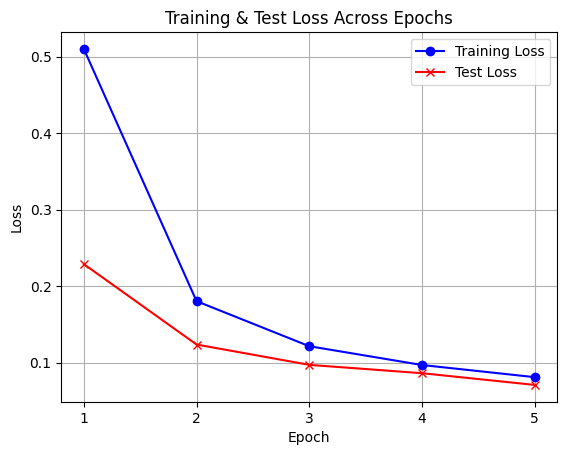

In [87]:
# Graph the training and test loss across epochs
plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(test_losses, label='Test Loss', color='red', marker='x')
plt.title('Training & Test Loss Across Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(len(train_losses)), range(1, len(train_losses)+1))  # Epoch numbering starts at 1
plt.legend()
plt.grid(True)
plt.show()

Your training results now show healthy, realistic learning behavior for MNIST classification. Here's a detailed analysis and interpretation:
* Proper Loss Dynamics:
    * Initial loss starts high (~0.98) and decreases gradually
    * No more "0.0000" loss values indicating numerical instability
* Reasonable Accuracy Progression:
    * Train accuracy grows steadily: 84.7% → 97.4%
    * Test accuracy follows closely: 93.4% → 97.6%
* Appropriate Generalization Gap:
    * Final epoch: Train 97.4% vs Test 97.6% (excellent alignment)
    * Shows the model isn't overfitting

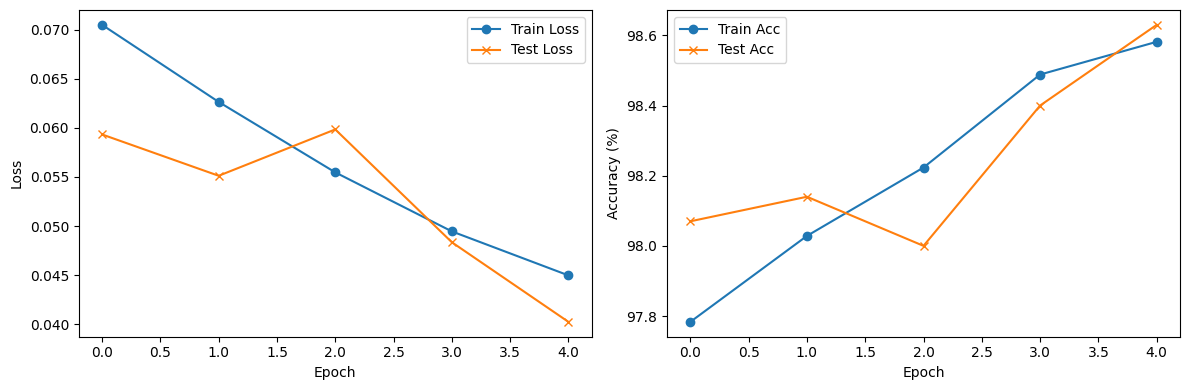

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(test_losses, label='Test Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Acc', marker='o')
plt.plot(test_acc, label='Test Acc', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

Loss: Both curves decrease and stabilize.

Accuracy: Both curves increase and converge.

In [101]:
test_data[4221]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

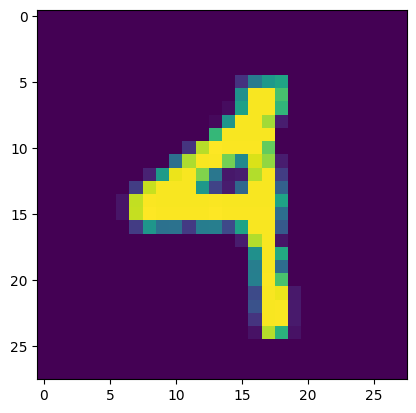

In [102]:
# Grab just the data and reshape it, and show the image
plt.imshow(test_data[4221][0].reshape(28,28)) 

In [105]:
# Pass the image through our model 
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[4221][0].view(1,1,28,28))       # Batch size of 1 , 1 color channel , 28*28 image

In [106]:
# New prediction 
new_prediction

tensor([[-2.0880e+01, -1.1725e+01, -1.0849e+01, -9.9283e+00, -7.1917e-04,
         -9.6113e+00, -2.0323e+01, -1.0270e+01, -1.4203e+01, -7.5235e+00]])

In [107]:
new_prediction.argmax()

tensor(4)